In [4]:
pip install psycopg2-binary sqlalchemy pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [9]:
import pandas as pd
from sqlalchemy import create_engine
# Connexion aux bases de données
user = 'postgres'
password = '123456a'
host = 'localhost'
port = '5432'

# 🔹 Connexion à la base FACTS
database_facts = 'FACTS'
engine_fact = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database_facts}')
query_fact = 'SELECT * FROM "Fact_Stock"'
df_fact = pd.read_sql(query_fact, engine_fact)

# 🔹 Connexion à la base DIMENSIONS
database_dim = 'DIMENSIONS'
engine_dim = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database_dim}')

query_iot = 'SELECT * FROM "DimIot"'
df_iot = pd.read_sql(query_iot, engine_dim)

query_products = 'SELECT * FROM "DimProducts"'
df_products = pd.read_sql(query_products, engine_dim)

# 🔁 Assurer la compatibilité des types
df_fact['Fk_Iot'] = df_fact['Fk_Iot'].astype(str)
df_iot['Pk_Iot'] = df_iot['Pk_Iot'].astype(str)

df_fact['Fk_Products'] = df_fact['Fk_Products'].astype(str)
df_products['Pk_Products'] = df_products['Pk_Products'].astype(str)

# 🔗 Jointure entre Fact_Stock et DimIot
merged_df = pd.merge(df_fact, df_iot, left_on='Fk_Iot', right_on='Pk_Iot', how='inner')

# 🔗 Jointure avec DimProducts pour récupérer productname et category
merged_df = pd.merge(merged_df, df_products, left_on='Fk_Products', right_on='Pk_Products', how='inner')
# Vérifier les noms des colonnes dans le DataFrame fusionné
print(merged_df.columns)
# 🧼 Colonnes utiles pour l'entraînement ML
final_df = merged_df[['productname_y', 'category', 'Temperature', 'Humidity', 'Status']]
final_df = final_df.rename(columns={'productname_y': 'productname'})  # Pour harmoniser le nom
# ✅ Afficher un aperçu
print(final_df.head())

Index(['QuantityInventory', 'CapacityWarehouse', 'Fk_Products',
       'Fk_ManufactureDate', 'Fk_ExpiryDate', 'FK_Inventory', 'Fk_Warehouses',
       'Fk_Iot', 'Temperature', 'Humidity', 'warehouseid', 'Pk_Iot',
       'Sensor_ID', 'productid_x', 'Status', 'productname_x', 'Pk_Products',
       'productid_y', 'productname_y', 'category', 'brandname', 'materialid',
       'materialname', 'materialcategory'],
      dtype='object')
    productname  category Temperature Humidity                         Status
0  Hair Serum 1  Haircare        21.1    79.42  Alerte Température & Humidité
1  Hair Serum 1  Haircare        21.1    79.42  Alerte Température & Humidité
2  Hair Serum 1  Haircare        21.1    79.42  Alerte Température & Humidité
3  Hair Serum 1  Haircare        21.1    79.42  Alerte Température & Humidité
4  Hair Serum 1  Haircare        21.1    79.42  Alerte Température & Humidité


In [10]:
# Convertir les colonnes 'Temperature' et 'Humidity' en float
final_df['Temperature'] = pd.to_numeric(final_df['Temperature'], errors='coerce')
final_df['Humidity'] = pd.to_numeric(final_df['Humidity'], errors='coerce')

# Vérifier les types après la conversion
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186600 entries, 0 to 186599
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   productname  186600 non-null  object 
 1   category     186600 non-null  object 
 2   Temperature  186600 non-null  float64
 3   Humidity     186600 non-null  float64
 4   Status       186600 non-null  object 
dtypes: float64(2), object(3)
memory usage: 7.1+ MB
None


In [11]:
final_df


,productname,category,Temperature,Humidity,Status
0,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité
1,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité
2,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité
3,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité
4,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité
...,...,...,...,...,...
186595,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité
186596,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité
186597,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité
186598,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité


In [12]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186600 entries, 0 to 186599
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   productname  186600 non-null  object 
 1   category     186600 non-null  object 
 2   Temperature  186600 non-null  float64
 3   Humidity     186600 non-null  float64
 4   Status       186600 non-null  object 
dtypes: float64(2), object(3)
memory usage: 7.1+ MB


In [13]:
final_df.describe()

,Temperature,Humidity
count,186600.000000,186600.000000
mean,21.641170,51.805811
std,2.724894,11.823660
min,15.020000,30.000000
25%,19.590000,42.490000
50%,21.460000,51.140000
75%,23.770000,60.190000
max,27.980000,79.850000


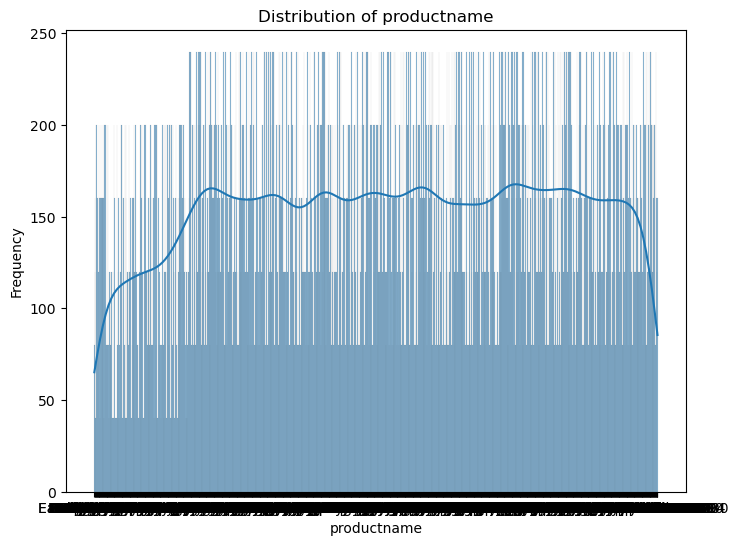

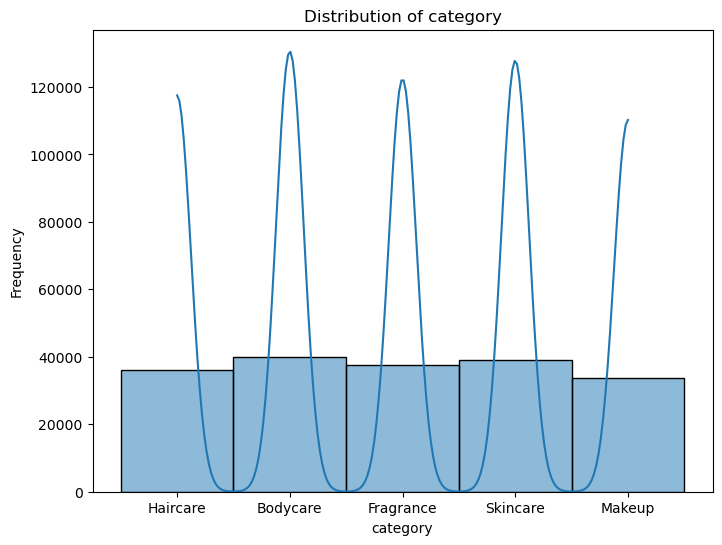

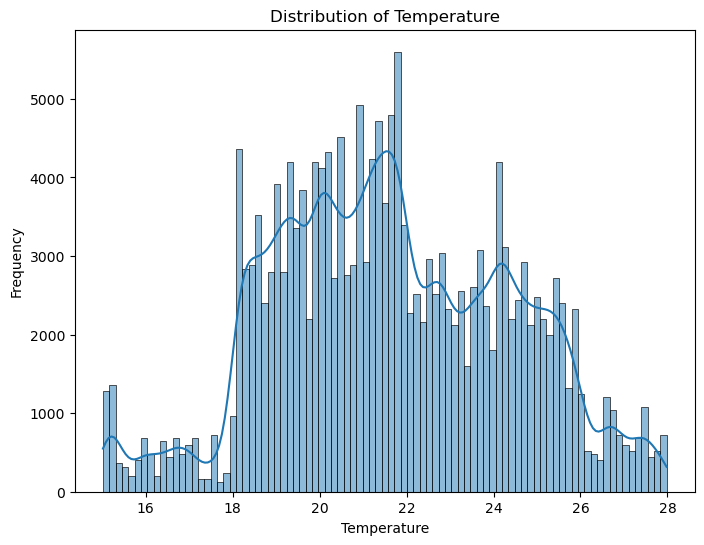

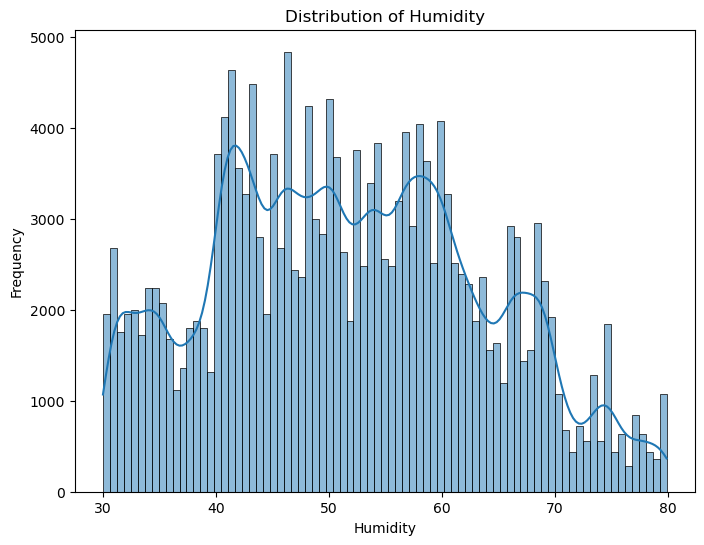

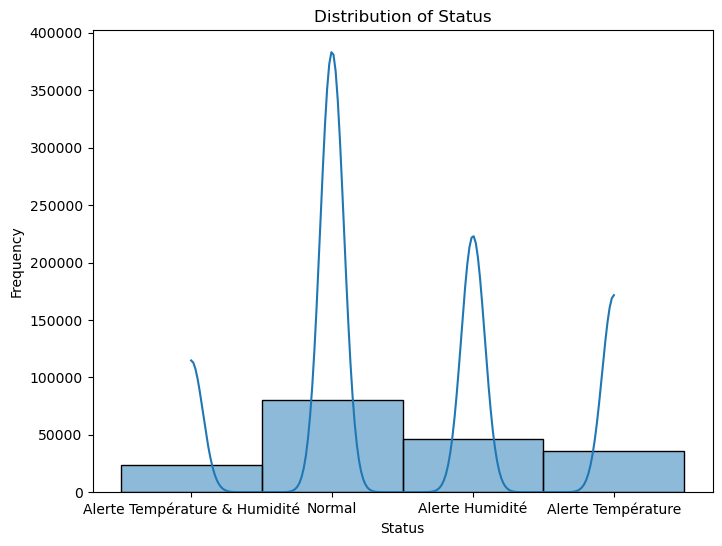

In [14]:
import matplotlib.pyplot as plt

import seaborn as sns

for column in final_df.columns:
  plt.figure(figsize=(8, 6))
  sns.histplot(final_df[column], kde=True)
  plt.title(f"Distribution of {column}")
  plt.xlabel(column)
  plt.ylabel("Frequency")
  plt.show()

In [15]:
corr = final_df.corr(numeric_only=True)
corr

,Temperature,Humidity
Temperature,1.000000,0.368268
Humidity,0.368268,1.000000


In [16]:
# Create the 'status_numerique' column based on the 'Status' column
status_mapping = {
    'Normal': 0,
    'Alerte Température': 1,
    'Alerte Humidité': 2,
    'Alerte Température & Humidité': 3
}
final_df['status_numerique'] = final_df['Status'].map(status_mapping)

In [17]:
final_df

,productname,category,Temperature,Humidity,Status,status_numerique
0,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité,3
1,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité,3
2,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité,3
3,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité,3
4,Hair Serum 1,Haircare,21.10,79.42,Alerte Température & Humidité,3
...,...,...,...,...,...,...
186595,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité,2
186596,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité,2
186597,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité,2
186598,Face Wash 1201,Skincare,23.54,66.14,Alerte Humidité,2


In [18]:
x = final_df[['Temperature', 'Humidity',]]
y = final_df['status_numerique']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import joblib

# Entraînement du modèle Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Prédiction
y_pred_gb = gb_model.predict(X_test)

# Rapport de classification
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))
# Sauvegarde du modèle
joblib.dump(gb_model, 'classification_produits_model.pkl')
import sklearn
print(sklearn.__version__)


Gradient Boosting:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     15957
           1       0.89      0.82      0.85      7289
           2       0.88      0.74      0.81      9172
           3       0.95      0.82      0.88      4902

    accuracy                           0.85     37320
   macro avg       0.88      0.83      0.85     37320
weighted avg       0.86      0.85      0.85     37320

1.3.0


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# 🧼 Données d'entrée : final_df
# Assurons-nous qu'il n'y a pas de valeurs manquantes
df_ml = final_df.dropna()

# 🧠 Caractéristiques (features) et cibles (targets)
X = df_ml[['productname', 'category']]
y = df_ml[['Temperature', 'Humidity']]

# 🔀 Séparation entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🏗️ Pipeline d'encodage + modèle
categorical_features = ['productname', 'category']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Modèle de régression
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 📦 Pipeline complet
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# 🚀 Entraînement
pipeline.fit(X_train, y_train)

# 📊 Évaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'📉 Mean Squared Error : {mse:.2f}')

# 🔮 Prédiction sur un nouveau produit
nouveau_produit = pd.DataFrame([{
    'productname': 'Hair Serum 1',
    'category': 'Haircare'
}])

prediction = pipeline.predict(nouveau_produit)
print(f"🧪 Prédiction : Température = {prediction[0][0]:.2f}°C, Humidité = {prediction[0][1]:.2f}%")


📉 Mean Squared Error : 0.00
🧪 Prédiction : Température = 21.10°C, Humidité = 79.42%


In [25]:
import joblib

# Sauvegarder le pipeline complet (prétraitement + modèle)
joblib.dump(pipeline, 'model_temperature_humidity.pkl')
print("✅ Modèle sauvegardé avec succès.")


✅ Modèle sauvegardé avec succès.
